# User Segmentation & Value Analysis (RFM Model)
Objectives:
- Segment e-commerce users based on RFM metrics
- Analyze value, satisfaction, and latency characteristics across different user segments
- Provide characteristics and business basis for subsequent churn prediction/precision marketing

In [26]:
# read data from sql:view_user_behavior
import pandas as pd
from src.utils.db import get_engine

# build connection with database
engine = get_engine()

# from view_user_behavior read "Aggregated behavioral data by user"
sql = "SELECT * FROM view_user_behavior"
df = pd.read_sql(sql, engine)

# close connection
engine.dispose()

# check head 5 row
df.head()

,user_id,city,state,order_count,total_spent,avg_order_value,last_purchase_date,days_since_last_purchase,first_purchase_date,customer_lifetime_days
0,0000366f3b9a7992bf8c76cfdf3221e2,cajamar,SP,1,141.90,141.90,2018-05-10 10:56:27,2849,2018-05-10 10:56:27,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,osasco,SP,1,27.19,27.19,2018-05-07 11:11:27,2852,2018-05-07 11:11:27,0
2,0000f46a3911fa3c0805444483337064,sao jose,SC,1,86.22,86.22,2017-03-10 21:05:03,3275,2017-03-10 21:05:03,0
3,0000f6ccb0745a6a4b88665a16c9f078,belem,PA,1,43.62,43.62,2017-10-12 20:29:41,3059,2017-10-12 20:29:41,0
4,0004aac84e0df4da2b147fca70cf8255,sorocaba,SP,1,196.89,196.89,2017-11-14 19:45:42,3026,2017-11-14 19:45:42,0


In [2]:
# check the data
print("Shape", df.shape)    # how much row\columns
print("\nInfo:", df.info()) # type of every column\if have null value

print("\nDescribe (Columns related to RFM):")
print(df[['order_count', 'total_spent', 'days_since_last_purchase']].describe())

print("\nMissing values:", df.isnull().sum())

Shape (99441, 10)
<class 'pandas.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   user_id                   99441 non-null  str           
 1   city                      99441 non-null  str           
 2   state                     99441 non-null  str           
 3   order_count               99441 non-null  int64         
 4   total_spent               98666 non-null  float64       
 5   avg_order_value           98666 non-null  float64       
 6   last_purchase_date        99441 non-null  datetime64[us]
 7   days_since_last_purchase  99441 non-null  int64         
 8   first_purchase_date       99441 non-null  datetime64[us]
 9   customer_lifetime_days    99441 non-null  int64         
dtypes: datetime64[us](2), float64(2), int64(3), str(3)
memory usage: 7.6 MB

Info: None

Describe (Columns related to RFM):
       order_co

In [3]:
# Clean up R/F/M fields(recency\frequency\monetary)
df_rfm = df.copy()

# Retain only: Users who have purchased at least once
df_rfm = df_rfm[df_rfm['order_count'] > 0].copy()

print("After filtering users with order_count > 0:")
print(df_rfm[['order_count', 'total_spent', 'days_since_last_purchase']].describe())

After filtering users with order_count > 0:
       order_count   total_spent  days_since_last_purchase
count      99441.0  98666.000000              99441.000000
mean           1.0    160.577638               2979.272956
std            0.0    220.466087                153.670615
min            1.0      9.590000               2689.000000
25%            1.0     61.980000               2855.000000
50%            1.0    105.290000               2961.000000
75%            1.0    176.870000               3089.000000
max            1.0  13664.080000               3462.000000


In [4]:
# Unified naming convention
df_rfm.rename(columns = {
    'days_since_last_purchase': 'recency',
    'order_count': 'frequency',
    'total_spent' : 'monetary'
}, inplace=True)

df_rfm[['user_id', 'recency', 'frequency', 'monetary']].head()

,user_id,recency,frequency,monetary
0,00012a2ce6f8dcda20d059ce98491703,3026,1,114.74
1,000161a058600d5901f007fab4c27140,3147,1,67.41
2,0001fd6190edaaf884bcaf3d49edf079,3285,1,195.42
3,0002414f95344307404f0ace7a26f1d5,3116,1,179.35
4,000379cdec625522490c315e70c7a9fb,2887,1,107.01


In [9]:
df_rfm[['recency', 'frequency', 'monetary']].isna().sum()

recency      0
frequency    0
monetary     0
dtype: int64

In [11]:
df_rfm = df_rfm.dropna(
    subset=['recency', 'frequency', 'monetary']
).copy()
# Recency scoring: The more recent the event, the higher the score.
'''
qcut will be divided into 5 parts according to the value from smallest to larger, here directly specify the tag [5,4,3,2,1], so that the most recent one gets 5 points
'''
df_rfm['R_score'] = pd.qcut(
    df_rfm['recency'],
    5,
    labels = [5, 4, 3, 2, 1]
).astype(int)

# Frequency scoring: more bigger, the higher score
'''
Rank first, then qcut to avoid too many duplicate values causing qcut errors
'''
df_rfm['F_score'] = pd.qcut(
    df_rfm['frequency'].rank(method='first'),
    5,
    labels=[5, 4, 3, 2, 1]
).astype(int)

# Monetary:bigger, better
df_rfm['M_score'] = pd.qcut(
    df_rfm['monetary'].rank(method='first'),
    5,
    labels=[1, 2, 3, 4, 5]
).astype(int)

# Simple total RFM score (3~15)
df_rfm['RFM_score'] = (
    df_rfm['R_score'] + df_rfm['F_score'] + df_rfm['M_score']
)

df_rfm[['user_id', 'recency', 'frequency', 'monetary', 'R_score', 'F_score', 'M_score', 'RFM_score']].head(20)

,user_id,recency,frequency,monetary,R_score,F_score,M_score,RFM_score
0,00012a2ce6f8dcda20d059ce98491703,3026,1,114.74,2,5,3,10
1,000161a058600d5901f007fab4c27140,3147,1,67.41,1,5,2,8
2,0001fd6190edaaf884bcaf3d49edf079,3285,1,195.42,1,5,4,10
3,0002414f95344307404f0ace7a26f1d5,3116,1,179.35,2,5,4,11
4,000379cdec625522490c315e70c7a9fb,2887,1,107.01,4,5,3,12
5,0004164d20a9e969af783496f3408652,3242,1,71.80,1,5,2,8
6,000419c5494106c306a97b5635748086,2918,1,49.40,4,5,1,10
7,00046a560d407e99b969756e0b10f282,2992,1,166.59,3,5,4,12
8,00050bf6e01e69d5c0fd612f1bcfb69c,3084,1,85.23,2,5,2,9
9,000598caf2ef4117407665ac33275130,2756,1,1255.71,5,5,5,15


In [16]:
# Select the features that will be used for clustering.
features = ['recency', 'frequency', 'monetary']

# standardscaler(All variables become the same scale.)
from sklearn.preprocessing import StandardScaler

x = df_rfm[features]

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

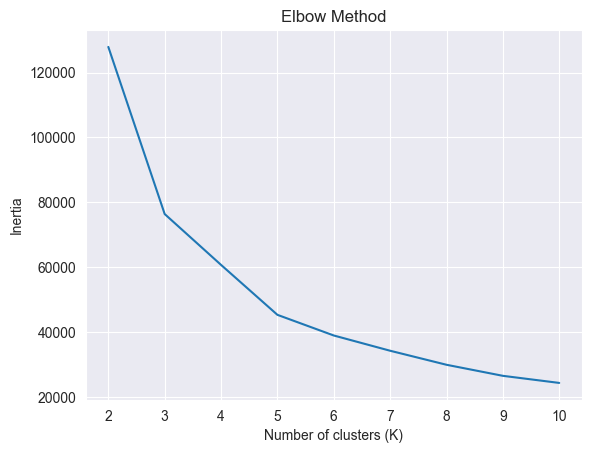

In [17]:
# K value
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K_range, inertia)
plt.xlabel("Number of clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

# Elbow Method map analysis
From the Elbow Method graph, it can be seen that with the increase of the number of clusters K, the Inertia (intra-class squared error) of the model continues to decrease, indicating that increasing the number of clusters can improve the degree of data fit. However, between K=2 and K=5, Inertia declines significantly more, while when K exceeds 5, the downward trend gradually slows down and the curve tends to be smoothed. This indicates that at K≥5, the model optimization effect brought about by continuing to increase the number of clusters is limited, and the marginal benefit is significantly reduced. Therefore, K=4 or K=5 are reasonable candidates. From the perspective of business interpretability, the 5 types of user groups are more conducive to the subsequent formulation of differentiated operation strategies, so this study tends to choose K=5 as the final clustering number.

In [18]:
from sklearn.metrics import silhouette_score

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(x_scaled)
    score = silhouette_score(x_scaled, labels)
    print(f"K={k}, Silhouette Score={score:.4f}")

K=2, Silhouette Score=0.4484
K=3, Silhouette Score=0.4844
K=4, Silhouette Score=0.4949
K=5, Silhouette Score=0.4278
K=6, Silhouette Score=0.4381
K=7, Silhouette Score=0.3711
K=8, Silhouette Score=0.3880
K=9, Silhouette Score=0.3959
K=10, Silhouette Score=0.3947


# Silhouette Score analysis
According to the Silhouette Score results of different cluster numbers of K, it can be seen that as K increases from 2 to 4, the profile coefficient continues to increase, reaching the highest value of 0.4949 at K=4, indicating that the internal structure of the cluster is the most compact and the interclass resolution is the best at this time. When K exceeds 4, the Silhouette Score decreases significantly, indicating that excessive clustering weakens the distinction between classes, resulting in a decrease in cluster quality. Therefore, considering the cluster tightness and resolution, K=4 is the optimal number of clusters.

Combined with the results of the previous Elbow Method, although K=5 is also reasonable, it is not as good as K=4 in the Silhouette index, so K=4 is finally selected as the number of user groups to ensure the stability and structural clarity of the model.

In [19]:
kmeans = KMeans(n_clusters=4, random_state=42)
df_rfm['cluster'] = kmeans.fit_predict(x_scaled)

In [20]:
# how many person in each cluster
df_rfm['cluster'].value_counts().sort_index()

cluster
0    39620
1    53376
2     5010
3      660
Name: count, dtype: int64

In [21]:
# rfm.mean for each cluster
cluster_profile = df_rfm.groupby('cluster')[
    ['recency', 'frequency', 'monetary']
].mean().round(2)

cluster_profile

,recency,frequency,monetary
cluster,,,
0,3129.55,1.0,122.14
1,2867.81,1.0,120.98
2,2967.31,1.0,653.71
3,2979.61,1.0,1927.06


In [22]:
# cluster_size
cluster_size = df_rfm['cluster'].value_counts(normalize=True).sort_index()
cluster_size

cluster
0    0.401557
1    0.540977
2    0.050777
3    0.006689
Name: proportion, dtype: float64

In [23]:
# find frequency always are 1
df_rfm['frequency'].describe()

count    98666.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: frequency, dtype: float64

In [24]:
df_rfm['frequency'].value_counts().sort_index()

frequency
1    98666
Name: count, dtype: int64